# Feature Engineering

In [1]:
import pandas as pd
import numpy as np
from plotnine import *
import shapely.geometry
import shapely.wkt
from shapely import wkt
import geopandas as gpd
from datetime import datetime

import s

import folium
import matplotlib
import mapclassify

In [2]:
PATH_RAW = '../data/raw/'
PATH_INTERIM = '../data/interim/'

In [141]:
# 50th Percentile
def q50(x):
    return x.quantile(0.5)
def q75(x):
    return x.quantile(0.75)
def q25(x):
    return x.quantile(0.25)

## Start Data Engineering

### Aggregate median jams kota bandung

In [4]:
df1 = pd.read_csv(PATH_RAW+"aggregate_median_jams_Kota Bandung_fixed.csv")
# df2 = pd.read_csv(PATH_RAW+"aggregate_median_jams_Kota Bandung_fixed.csv")

In [5]:
df1.sample(5)

,Unnamed: 0,time,kemendagri_kabupaten_kode,kemendagri_kabupaten_nama,street,level,median_length,median_delay,median_speed_kmh,total_records,id,date,median_level,geometry
7558,2415,2022-07-07 14:00:00.000,32.73,KOTA BANDUNG,Jalan Serayu,4,214.0,112.0,4.85,6,33538914,2022-07-07,4.0,"MULTILINESTRING ((107.627041 -6.90859, 107.625..."
135630,117763,2022-08-02 05:00:00.000,32.73,KOTA BANDUNG,N11 Flyover Kopo-Cibaduyut,5,1194.0,-1.0,0.00,120,35215658,2022-08-02,5.0,"MULTILINESTRING ((107.597781 -6.94756, 107.596..."
249941,100063,2022-08-26 08:00:00.000,32.73,KOTA BANDUNG,Sukajadi,1,1961.0,97.0,25.42,6,36641320,2022-08-26,1.0,"MULTILINESTRING ((107.597341 -6.896948, 107.59..."
167903,18025,2022-08-09 13:00:00.000,32.73,KOTA BANDUNG,KH Wahid Hasyim,2,1008.0,99.5,17.32,58,35680184,2022-08-09,2.0,"MULTILINESTRING ((107.58792 -6.948258, 107.586..."
268575,118697,2022-08-29 14:00:00.000,32.73,KOTA BANDUNG,Haji Tatang Sumantri,4,209.0,182.0,3.19,23,36850546,2022-08-29,4.0,"MULTILINESTRING ((107.609761 -6.954935, 107.61..."


In [6]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 301995 entries, 0 to 301994
Data columns (total 14 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   Unnamed: 0                 301995 non-null  int64  
 1   time                       301995 non-null  object 
 2   kemendagri_kabupaten_kode  301995 non-null  float64
 3   kemendagri_kabupaten_nama  301995 non-null  object 
 4   street                     299552 non-null  object 
 5   level                      301995 non-null  int64  
 6   median_length              301995 non-null  float64
 7   median_delay               301995 non-null  float64
 8   median_speed_kmh           301995 non-null  float64
 9   total_records              301995 non-null  int64  
 10  id                         301995 non-null  int64  
 11  date                       301995 non-null  object 
 12  median_level               301995 non-null  float64
 13  geometry                   30

### Time

In [7]:
df1.time = pd.to_datetime(df1.time)

In [8]:
df1['thm'] = [str(time.hour) + ":" + str(time.minute) for time in df1.time]


In [14]:
print("cols:", df1.columns)
print("thm:",set(df1.thm))

cols: Index(['Unnamed: 0', 'time', 'kemendagri_kabupaten_kode',
       'kemendagri_kabupaten_nama', 'street', 'level', 'median_length',
       'median_delay', 'median_speed_kmh', 'total_records', 'id', 'date',
       'median_level', 'geometry', 'thm'],
      dtype='object')
thm: {'3:0', '23:0', '12:0', '5:0', '15:0', '11:0', '7:0', '8:0', '1:0', '2:0', '13:0', '17:0', '19:0', '22:0', '9:0', '4:0', '20:0', '10:0', '21:0', '6:0', '16:0', '0:0', '14:0', '18:0'}


### Date
Holiday and weekend

In [21]:
df1.date = pd.to_datetime(df1.date)

In [59]:
libur = [
  pd.Timestamp('2022-07-08'),
  pd.Timestamp('2022-07-30'),
  pd.Timestamp('2022-08-17'),
]

is_holiday = []
is_weekend = []
for date in df1.date:
  if date in libur or date.dayofweek in [5,6]:
    is_holiday.append(1)
  else:
    is_holiday.append(0)

  if date.dayofweek in [5,6]:
    is_weekend.append(1)
  else:
    is_weekend.append(0)

In [71]:
df1['is_weekend'] = is_weekend
df1['is_holiday'] = is_holiday

In [73]:
df1.sample(2)

,Unnamed: 0,time,kemendagri_kabupaten_kode,kemendagri_kabupaten_nama,street,level,median_length,median_delay,median_speed_kmh,total_records,id,date,median_level,geometry,thm,is_weekend,is_holiday
145847,127980,2022-08-04 07:00:00,32.73,KOTA BANDUNG,Jalan Belitung,2,497.0,68.0,12.920,1,35331725,2022-08-04,2.0,"LINESTRING (107.617605 -6.911498, 107.616168 -...",7:0,0,0
203115,53237,2022-08-16 10:00:00,32.73,KOTA BANDUNG,Trunojoyo,2,782.0,81.0,15.325,10,36092837,2022-08-16,2.0,"MULTILINESTRING ((107.612808 -6.907011, 107.61...",10:0,0,0


### Hours

In [75]:
df1['hour'] = [time.hour for time in df1.time]

In [108]:
cnt_report = df1.groupby('hour').sum('total_records').reset_index().iloc[:,0:2]
cnt_report.columns = ['hour','sum']
cnt_report.sample(2)

,hour,sum
19,19,1295406723
14,14,1741893484


### SUM reports per time

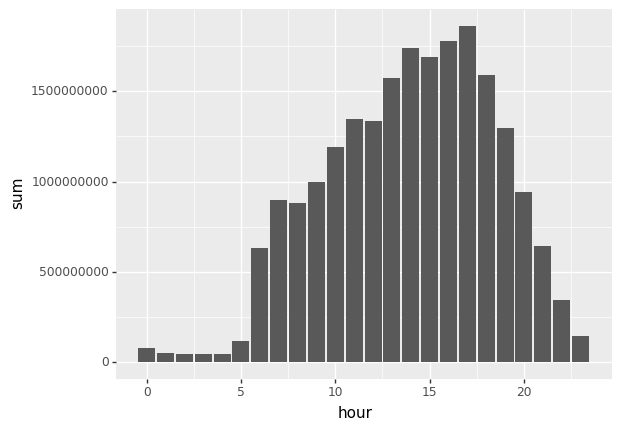

<ggplot: (126628325003)>

In [112]:
(
  ggplot(cnt_report) +
  aes(x="hour",y='sum') +
  geom_col()
)

# peak hour 13 - 18
# busy hour 6 - 23

In [118]:
# [hour for hour in df1.hour if hour >=13 and hour <= 18]
df1['peak_hour'] = np.where((df1['hour'] >= 13) & (df1['hour'] <= 18), 1, 0)
df1['busy_hour'] = np.where((df1['hour'] >= 6) & (df1['hour'] <= 23), 1, 0)

In [120]:
df1.sample(1)

,Unnamed: 0,time,kemendagri_kabupaten_kode,kemendagri_kabupaten_nama,street,level,median_length,median_delay,median_speed_kmh,total_records,id,date,median_level,geometry,thm,is_weekend,is_holiday,hour,peak_hour,busy_hour
97527,79660,2022-07-25 16:00:00,32.73,KOTA BANDUNG,Jenderal Ibrahim Adjie,4,469.0,265.0,5.905,18,34710535,2022-07-25,4.0,"MULTILINESTRING ((107.642349 -6.939236, 107.64...",16:0,0,0,16,1,1


#### Holiday Total Records Metrics
mean, q50, q75, q25

In [152]:
h_g_f1 = df1.groupby('is_holiday')
h_g_f1_sum = h_g_f1.agg({
  'total_records': np.sum
}).reset_index()

In [174]:
h_g_f1_q75 = h_g_f1.agg({
  'total_records': q75
}).reset_index()
h_g_f1_q75

,is_holiday,total_records
0,0,25.0
1,1,25.0


In [178]:
h_g_f1_q50 = h_g_f1.agg({
  'total_records': q50
}).reset_index()
h_g_f1_q50

,is_holiday,total_records
0,0,11.0
1,1,10.0


In [150]:
h_g_f1_q25 = h_g_f1.agg({
  'total_records': q25
}).reset_index()

In [149]:
h_g_f1_mean = h_g_f1.agg({
  'total_records': np.mean
}).reset_index()

In [167]:
df1['total_records_holiday_sum'] = np.where(df1['is_holiday'], h_g_f1_sum.iloc[0,1], h_g_f1_sum.iloc[1,1])

In [170]:
df1.sample(2)

,Unnamed: 0,time,kemendagri_kabupaten_kode,kemendagri_kabupaten_nama,street,level,median_length,median_delay,median_speed_kmh,total_records,...,date,median_level,geometry,thm,is_weekend,is_holiday,hour,peak_hour,busy_hour,total_records_holiday_sum
34235,16368,2022-07-14 00:00:00,32.73,KOTA BANDUNG,Cingised,3,302.0,118.5,6.47,8,...,2022-07-14,3.0,"MULTILINESTRING ((107.67293 -6.928174, 107.672...",0:0,0,0,0,0,0,2012056
277119,127241,2022-08-31 11:00:00,32.73,KOTA BANDUNG,Cihapit,4,333.0,214.0,4.39,1,...,2022-08-31,4.0,"LINESTRING (107.621463 -6.908303, 107.62147 -6...",11:0,0,0,11,0,1,2012056


In [179]:
df1['total_records_holiday_q25'] = np.where(df1['is_holiday'], h_g_f1_q25.iloc[0,1], h_g_f1_q25.iloc[1,1])
df1['total_records_holiday_q75'] = np.where(df1['is_holiday'], h_g_f1_q75.iloc[0,1], h_g_f1_q75.iloc[1,1])
df1['total_records_holiday_q50'] = np.where(df1['is_holiday'], h_g_f1_q50.iloc[0,1], h_g_f1_q50.iloc[1,1])
df1['total_records_holiday_mean'] = np.where(df1['is_holiday'], h_g_f1_mean.iloc[0,1], h_g_f1_mean.iloc[1,1])

In [175]:
df1.sample(2)

,Unnamed: 0,time,kemendagri_kabupaten_kode,kemendagri_kabupaten_nama,street,level,median_length,median_delay,median_speed_kmh,total_records,...,thm,is_weekend,is_holiday,hour,peak_hour,busy_hour,total_records_holiday_sum,total_records_holiday_q25,total_records_holiday_q75,total_records_holiday_mean
112784,94917,2022-07-28 18:00:00,32.73,KOTA BANDUNG,Holis,4,201.0,130.0,4.61,1,...,18:0,0,0,18,1,1,2012056,4.0,25.0,21.431526
189527,39649,2022-08-13 15:00:00,32.73,KOTA BANDUNG,N11 Soekarno-Hatta,2,1428.0,100.0,22.70,128,...,15:0,1,1,15,1,1,4433653,4.0,25.0,21.304168


#### Busy Hour Total Records Metrics
sum, mean, q50, q75, q25

In [182]:
b_g_f1 = df1.groupby('busy_hour')
b_g_f1_sum = b_g_f1.agg({
  'total_records': np.sum
}).reset_index()
b_g_f1_sum

,busy_hour,total_records
0,0,304513
1,1,6141196


In [189]:
b_g_f1_mean = b_g_f1.agg({
  'total_records': np.mean
}).reset_index()

In [190]:
b_g_f1_q25 = b_g_f1.agg({
  'total_records': q25
}).reset_index()

In [191]:
b_g_f1_q50 = b_g_f1.agg({
  'total_records': q50
}).reset_index()

In [192]:
b_g_f1_q75 = b_g_f1.agg({
  'total_records': q75
}).reset_index()

In [194]:
df1['total_records_busy_hour_mean'] = np.where(df1['busy_hour'], b_g_f1_mean.iloc[0,1], b_g_f1_mean.iloc[1,1])
df1['total_records_busy_hour_sum'] = np.where(df1['busy_hour'], b_g_f1_sum.iloc[0,1], b_g_f1_mean.iloc[1,1])
df1['total_records_busy_hour_q25'] = np.where(df1['busy_hour'], b_g_f1_q25.iloc[0,1], b_g_f1_mean.iloc[1,1])
df1['total_records_busy_hour_q50'] = np.where(df1['busy_hour'], b_g_f1_q50.iloc[0,1], b_g_f1_mean.iloc[1,1])
df1['total_records_busy_hour_q75'] = np.where(df1['busy_hour'], b_g_f1_q75.iloc[0,1], b_g_f1_mean.iloc[1,1])

In [197]:
df1.to_csv(PATH_INTERIM+"iterim1.csv")